# Part 3: Time Series Focus on Modularity Optimized Financial Data
## Background
Building upon my data engineering and analysis from [Part 2](https://github.com/naomatheus/modulariti-opt-public), I now implement advanced time series analysis techniques to identify meaningful and actionable information within the NASDAQ 100 stock dataset that has been optimized for community detection.

The applied techniques revealed coherent structure hidden within the complex  financial data. I explore techniques that bring actionable insights to the fore by examining trends and empirical aspects to highlight portfolio optimization strategies fit to this dataset.

Lastly, I demonstrate that even a basic "community rotation" strategy can be efficient in practice.

In [12]:
# imports
# import cupy as cp
import matplotlib.pyplot as plt
import pandas as pd
from itertools import product
# import cudf
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, pacf, acf, coint
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings
warnings.filterwarnings('ignore')
import numpy as np

## Problem Definition

**General Business Case:**

Infer a network between stocks using newly engineered stock performance features.

**Prior Papers:**

Sukma, Narongsak & Namahoot, Chakkrit. (2024). [An Algorithmic Trading Approach Merging Machine Learning With Multi-Indicator Strategies for Optimal Performance](https://www.researchgate.net/publication/387006426_An_Algorithmic_Trading_Approach_Merging_Machine_Learning_with_Multi-Indicator_Strategies_for_Optimal_Performance). IEEE Access. PP. 1-1. 10.1109/ACCESS.2024.3516053.

- Sukma and Namashoot show that well-performing stock portfolios can be constructed combining machine learning with both traditional and novel indicators.

[Community detection and portfolio optimization](https://arxiv.org/abs/2112.13383) (2021)
Longfeng Zhao, Chao Wang, Gang-Jin Wang, H. Eugene Stanley, Lin Chen
- Zhao, et. al. applied Modularity Optimization to create Planar Maximally Filtered Graphs (PMFGs) containing stocks and demonstrated the development of  well-performing, efficiently diversified portfolios.


In [2]:
# if running this in Google Colab - connect google drive
from google.colab import drive
drive.mount('/content/gdrive')
# Read in data created from previous notebook Part 1
DATA_PATH = "/content/gdrive/MyDrive/Portfolio_Berkeley"
# prepare paths
volatility_data = "volatility_network.csv"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# load data into pandas dataframes
vol_df = pd.read_csv(f"{DATA_PATH}/{volatility_data}")

vol_df.head(10)

,Unnamed: 0,_VERTEX_,Date,Open,High,Low,Close,Adj Close,Volume,Name,volatility,pcp,vwap,_TYPE_,volatility_change,source,destination,edge_id,scaled_volatility_change,partition
0,0,2012-09-28,2012-09-28,32.65,32.93,32.39,32.44,32.44,4017900,ADBE,1.6539,-0.6432,32.5867,TradingDay,-0.072072,2012-09-28_ADBE,2012-10-01_ADBE,3391173485,0.427029,985
1,1,2012-10-01,2012-10-01,32.58,32.85,32.35,32.62,32.62,5201900,ADBE,1.5347,0.1228,32.6067,TradingDay,0.171369,2012-10-01_ADBE,2012-10-02_ADBE,1481334398,0.539060,985
2,2,2012-10-02,2012-10-02,32.82,32.91,32.32,32.57,32.57,3381600,ADBE,1.7977,-0.7617,32.6000,TradingDay,-0.439172,2012-10-02_ADBE,2012-10-03_ADBE,2539601162,0.258091,985
3,3,2012-10-03,2012-10-03,32.73,32.85,32.52,32.60,32.60,2455700,ADBE,1.0082,-0.3972,32.6567,TradingDay,0.798453,2012-10-03_ADBE,2012-10-04_ADBE,801188534,0.827642,985
4,4,2012-10-04,2012-10-04,32.54,32.79,32.20,32.68,32.68,3886900,ADBE,1.8132,0.4302,32.5567,TradingDay,0.075116,2012-10-04_ADBE,2012-10-05_ADBE,2137622493,0.494765,985
5,5,2012-10-05,2012-10-05,32.83,33.03,32.39,32.47,32.47,2505100,ADBE,1.9494,-1.0966,32.6300,TradingDay,-0.284446,2012-10-05_ADBE,2012-10-08_ADBE,1520965290,0.329295,985
6,6,2012-10-08,2012-10-08,32.26,32.47,32.02,32.23,32.23,2154800,ADBE,1.3949,-0.0930,32.2400,TradingDay,0.535236,2012-10-08_ADBE,2012-10-09_ADBE,647829353,0.706510,985
7,7,2012-10-09,2012-10-09,32.22,32.25,31.56,31.69,31.69,3504400,ADBE,2.1415,-1.6449,31.8333,TradingDay,-0.306327,2012-10-09_ADBE,2012-10-10_ADBE,1174971916,0.319226,985
8,8,2012-10-10,2012-10-10,31.64,31.80,31.33,31.51,31.51,2481700,ADBE,1.4855,-0.4109,31.5467,TradingDay,-0.302524,2012-10-10_ADBE,2012-10-11_ADBE,2779694176,0.320976,985
9,9,2012-10-11,2012-10-11,31.85,31.91,31.58,31.78,31.78,2854600,ADBE,1.0361,-0.2198,31.7567,TradingDay,0.093331,2012-10-11_ADBE,2012-10-12_ADBE,4279429870,0.503147,985


## Setup

Use proper time series format and data structure

In [4]:
date_column = 'Date'


# Load data into pandas dataframe
vol_df = pd.read_csv(f"{DATA_PATH}/{volatility_data}")

# Convert the date column to proper datetime
vol_df[date_column] = pd.to_datetime(vol_df[date_column])

# Sort by date index and set as index
vol_df = vol_df.sort_index()
vol_df = vol_df.set_index(date_column)

# Verify the time index
print("Index dtype:", vol_df.index.dtype)
print("Date range:", vol_df.index.min(), "to", vol_df.index.max())
print("Total days:", len(vol_df))
print("Frequency check - first few dates:")
print(vol_df.index[:10])

Index dtype: datetime64[ns]
Date range: 2010-01-04 00:00:00 to 2021-09-08 00:00:00
Total days: 271476
Frequency check - first few dates:
DatetimeIndex(['2012-09-28', '2012-10-01', '2012-10-02', '2012-10-03',
               '2012-10-04', '2012-10-05', '2012-10-08', '2012-10-09',
               '2012-10-10', '2012-10-11'],
              dtype='datetime64[ns]', name='Date', freq=None)


## Visual Inspection of Volatility TS

I'll pick two individual technology stocks for this demo.
- AAPL : Apple
- BIDU : Baidu

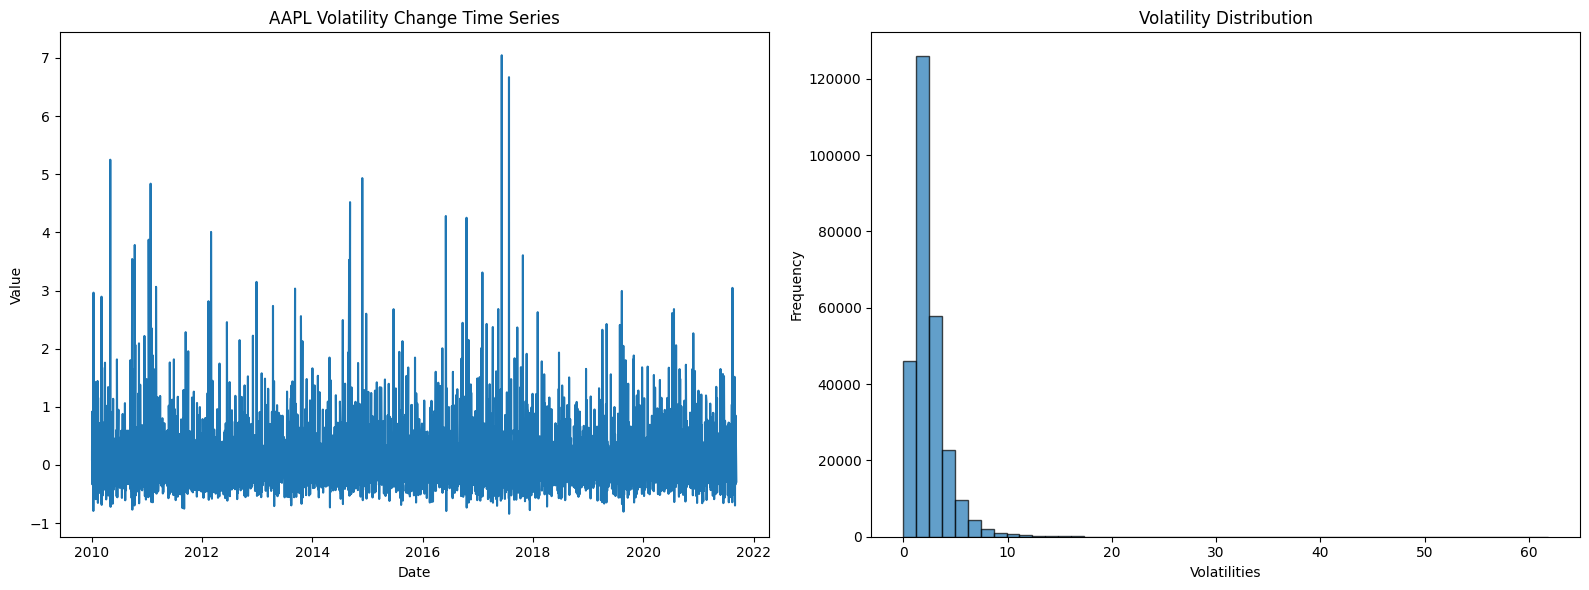

In [23]:
single_stock = vol_df[vol_df['Name'] == 'AAPL']

# Sort the single stock data by date index
single_stock = single_stock.sort_index()

def gpu_timeseries_plot(data, ax=None):
    if ax is None:
        plt.figure(figsize=(10, 6))
        ax = plt.gca()

    x_values = data.index  # Date index
    y_values = data.values  # volatility_change values

    ax.plot(x_values, y_values)
    ax.set_title('AAPL Volatility Change Time Series')
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')

def gpu_histogram(data, bins=50, ax=None):
    if ax is None:
        plt.figure(figsize=(10, 6))
        ax = plt.gca()

    ax.hist(data.values, bins=bins, alpha=0.7, edgecolor='black')
    ax.set_title('Volatility Distribution')
    ax.set_xlabel('Volatilities')
    ax.set_ylabel('Frequency')

# Create side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
gpu_timeseries_plot(single_stock['volatility_change'], ax=ax1)
gpu_histogram(vol_df['volatility'], ax=ax2)
plt.tight_layout()
plt.show()


ACF & PACF

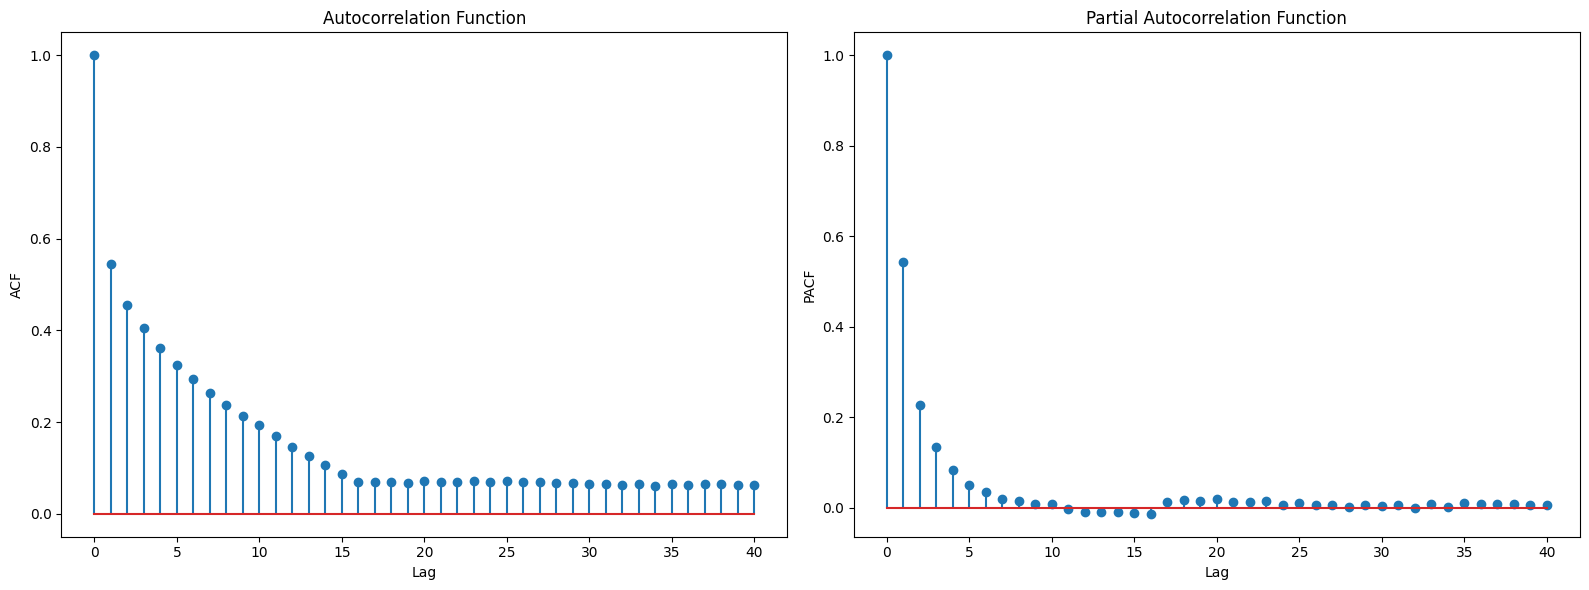

In [24]:
def gpu_acf_plot(data, lags=40, ax=None):
    acf_values = acf(data.values, nlags=lags)

    if ax is None:
        plt.figure(figsize=(12, 6))
        ax = plt.gca()

    ax.stem(range(len(acf_values)), acf_values)
    ax.set_title('Autocorrelation Function')
    ax.set_xlabel('Lag')
    ax.set_ylabel('ACF')

def gpu_pacf_plot(data, lags=40, ax=None):
    pacf_values = pacf(data.values, nlags=lags)

    if ax is None:
        plt.figure(figsize=(12, 6))
        ax = plt.gca()

    ax.stem(range(len(pacf_values)), pacf_values)
    ax.set_title('Partial Autocorrelation Function')
    ax.set_xlabel('Lag')
    ax.set_ylabel('PACF')

# side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
gpu_acf_plot(vol_df['volatility'], ax=ax1)
gpu_pacf_plot(vol_df['volatility'], ax=ax2)
plt.tight_layout()
plt.show()


These ACF and PACF plots show characteristics of a mixed MA/AR process, and this suggests that an ARIMA mode may be required in order to model the autogressive and moving average processes that appear to exist in the volatility metric of the data.

## Modeling & Tests for Stationarity, Cointegration, Correlation

Panel Data Structure with Multiple Stock Names and Date Observations

In [7]:
# Convert to proper panel structure (MultiIndex)
panel_df = vol_df.reset_index().set_index(['Date', 'Name'])
print("Panel structure:", panel_df.index.names)
print("Panel shape:", panel_df.shape)
panel_df.head()
panel_df.describe()

Panel structure: ['Date', 'Name']
Panel shape: (271476, 18)


,Unnamed: 0,Open,High,Low,Close,Adj Close,Volume,volatility,pcp,vwap,volatility_change,edge_id,scaled_volatility_change,partition
count,271476.000000,271476.000000,271476.000000,271476.000000,271476.000000,271476.000000,2.714760e+05,271476.000000,271476.000000,271476.000000,271476.000000,2.714760e+05,271476.000000,271476.000000
mean,135737.500000,129.971531,131.501777,128.391312,130.000612,126.753930,1.053058e+07,2.481154,0.047831,129.964567,0.131406,2.149892e+09,0.520669,631.257316
std,78368.515177,258.985242,261.771909,256.052726,258.990386,259.691851,3.926122e+07,1.689943,1.747459,258.930561,0.639096,1.241621e+09,0.294110,374.029059
min,0.000000,0.610000,0.660000,0.610000,0.650000,0.612300,0.000000e+00,0.000000,-27.090300,0.640000,-1.000000,3.072800e+04,0.000000,0.000000
25%,67868.750000,32.530000,32.940000,32.139875,32.560000,27.992075,1.332575e+06,1.423500,-0.800500,32.546700,-0.281466,1.073335e+09,0.330667,309.000000
50%,135737.500000,59.770000,60.470000,59.090000,59.810000,55.561300,2.760000e+06,2.038200,0.047300,59.785000,-0.011201,2.149936e+09,0.455042,617.000000
75%,203606.250000,117.020000,118.350000,115.702500,117.070000,114.542500,6.890925e+06,3.007825,0.891800,117.050825,0.371439,3.230254e+09,0.631132,949.000000
max,271475.000000,3744.000000,3773.080100,3696.790000,3731.409900,3731.409900,1.880998e+09,61.808000,40.454200,3724.210000,20.729836,4.294948e+09,10.000000,1290.000000


Stationarity in AAPL and BIDU (Apple and Baidu)

In [8]:
def test_stationarity(data, stock_name):
    """Test if the time series is stationary"""
    result = adfuller(data.dropna())
    print(f"\n{stock_name} - ADF Stationarity Test:")
    print(f"ADF Statistic: {result[0]:.6f}")
    print(f"p-value: {result[1]:.6f}")
    print(f"Lag Param Used: {result[2]:.6f}")
    print(f"N Observations: {result[3]:.1f}")
    print(f"BIC: {result[5]:.2f}")

    if result[1] <= 0.05:
        print("✓ Reject null of non-stationarity")
        return True
    else:
        print("✗ Fail to Reject. Series is non-stationary - consider differencing")
        return False

# Test for AAPL
aapl_data = panel_df.xs('AAPL', level='Name')['volatility'].sort_index()
test_stationarity(aapl_data, 'AAPL')

# Test for BIDU
bidu_data = panel_df.xs('BIDU', level='Name')['volatility'].sort_index()
test_stationarity(bidu_data, 'BIDU')


AAPL - ADF Stationarity Test:
ADF Statistic: -9.596930
p-value: 0.000000
Lag Param Used: 9.000000
N Observations: 2931.0
BIC: 8314.33
✓ Reject null of non-stationarity

BIDU - ADF Stationarity Test:
ADF Statistic: -7.511749
p-value: 0.000000
Lag Param Used: 15.000000
N Observations: 2925.0
BIC: 10586.02
✓ Reject null of non-stationarity


True

Cointegration Tests

In [14]:
def phillips_ouliaris_test(series1, series2, name1, name2):
    """
    Phillips-Ouliaris Cointegration Test
    H0: No cointegration (series are not cointegrated)
    H1: Series are cointegrated
    """
    print(f"\nPhillips-Ouliaris Cointegration Test: {name1} vs {name2}")
    print("="*60)

    # Align the series by common dates
    common_dates = series1.index.intersection(series2.index)
    s1_aligned = series1.loc[common_dates].dropna()
    s2_aligned = series2.loc[common_dates].dropna()

    # Further align to ensure same length
    min_len = min(len(s1_aligned), len(s2_aligned))
    s1_final = s1_aligned.iloc[:min_len]
    s2_final = s2_aligned.iloc[:min_len]

    print(f"Sample size: {len(s1_final)} observations")
    print(f"Date range: {s1_final.index.min()} to {s1_final.index.max()}")

    # Run Phillips-Ouliaris test
    test_stat, p_value, crit_values = coint(s1_final, s2_final)

    print(f"\nTest Results:")
    print(f"Test Statistic: {test_stat:.6f}")
    print(f"P-value: {p_value:.6f}")
    print(f"Critical Values:")
    print(f"  1%: {crit_values[0]:.6f}")
    print(f"  5%: {crit_values[1]:.6f}")
    print(f"  10%: {crit_values[2]:.6f}")

    # Interpretation
    if p_value < 0.05:
        print("✓ REJECT null hypothesis")
        print("✓ Evidence of COINTEGRATION between the series")
        print("✓ Long-run equilibrium relationship exists")
    else:
        print("✗ FAIL TO REJECT null hypothesis")
        print("✗ NO evidence of cointegration")
        print("✗ Series may drift apart in the long run")

    return test_stat, p_value, crit_values

# Run the Phillips-Ouliaris test
test_stat, p_value, crit_values = phillips_ouliaris_test(
    aapl_data,
    bidu_data,
    'AAPL',
    'BIDU'
)


Phillips-Ouliaris Cointegration Test: AAPL vs BIDU
Sample size: 2941 observations
Date range: 2010-01-04 00:00:00 to 2021-09-08 00:00:00

Test Results:
Test Statistic: -9.936438
P-value: 0.000000
Critical Values:
  1%: -3.900169
  5%: -3.338209
  10%: -3.045893
✓ REJECT null hypothesis (p < 0.05)
✓ Evidence of COINTEGRATION between the series
✓ Long-run equilibrium relationship exists


AutoARIMA Model with Two Stationary Series

In [11]:

def reliable_auto_arima(data, stock_name):
    """Reliable ARIMA model selection that works in any environment"""
    print(f"Searching best ARIMA for {stock_name}...")

    best_aic = float('inf')
    best_order = None
    best_model = None
    results = []

    # Test reasonable combinations - this is what auto_arima does anyway
    for p in range(6):      # AR terms
        for d in range(3):  # Differencing (0, 1, 2 is usually enough)
            for q in range(6):  # MA terms
                if p == 0 and d == 0 and q == 0:
                    continue
                try:
                    model = ARIMA(data, order=(p, d, q)).fit()
                    results.append((p, d, q, model.aic))

                    if model.aic < best_aic:
                        best_aic = model.aic
                        best_order = (p, d, q)
                        best_model = model

                except:
                    continue

    print(f"Best ARIMA{best_order} - AIC: {best_aic:.2f}")

    # Show top 5 models
    results.sort(key=lambda x: x[3])
    print(f"Top 5 models for {stock_name}:")
    for i, (p, d, q, aic) in enumerate(results[:5]):
        print(f"{i+1}. ARIMA({p},{d},{q}) - AIC: {aic:.2f}")

    return best_model

# Select models - this will definitely work
print("AAPL Model Selection:")
aapl_model = reliable_auto_arima(aapl_data, 'AAPL')

print("\nBIDU Model Selection:")
bidu_model = reliable_auto_arima(bidu_data, 'BIDU')

# Display summaries
print("\n" + "="*50)
print("AAPL ARIMA Model Summary:")
print("="*50)
print(aapl_model.summary())

print("\n" + "="*50)
print("BIDU ARIMA Model Summary:")
print("="*50)
print(bidu_model.summary())

AAPL Model Selection:
Searching best ARIMA for AAPL...
Best ARIMA(2, 0, 1) - AIC: 8405.41
Top 5 models for AAPL:
1. ARIMA(2,0,1) - AIC: 8405.41
2. ARIMA(2,0,2) - AIC: 8407.37
3. ARIMA(3,0,1) - AIC: 8407.38
4. ARIMA(1,0,4) - AIC: 8408.55
5. ARIMA(4,0,1) - AIC: 8408.66

BIDU Model Selection:
Searching best ARIMA for BIDU...
Best ARIMA(3, 0, 1) - AIC: 10665.60
Top 5 models for BIDU:
1. ARIMA(3,0,1) - AIC: 10665.60
2. ARIMA(2,0,2) - AIC: 10665.72
3. ARIMA(3,0,3) - AIC: 10666.66
4. ARIMA(2,0,3) - AIC: 10667.54
5. ARIMA(4,0,1) - AIC: 10667.55

AAPL ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:             volatility   No. Observations:                 2941
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -4197.703
Date:                Mon, 04 Aug 2025   AIC                           8405.406
Time:                        21:42:58   BIC                           8435.338
Sample:                            

## Simulation: Making Decisions from Network Structure Metrics

Here I demonstrate a Community Rotation Strategy, a systematic approach that groups stocks into communities based on their correlation patterns using the Leiden modularity optimization network analysis algorithm. The strategy works by grouping and identifying clusters of stocks that exhibit similar market behavior and risk characteristics based on their over-time volatility deltas.

Every 42 trading days, the strategy evaluates each community's performance using a risk-adjusted score (RAS). The RAS is calculated using the average return of member stock's divided by average community volatility. The result is a Sharpe-like ratio that captures both performance and risk within each community. Then the strategy rotates the entire portfolio into the community with the highest score, liquidates current positions, and reinvests equally across all stocks in the newly selected community.

**So why does this approach appear to work?**

This approach takes advantage of regime changes in market leadership by systematically moving capital toward the most attractive risk-return opportunity. I use the community-based framework to get natural diversification within each selection and to reduce the complexity of analyzing individual stocks. One can imagine adjusting the risk-reward metrics, periodic rotation, and the intra-community allocation to add more flexibility to this approach.

Overall, the portfolio here adapts to evolving market conditions and captures emerging trends across different sectors or market segments.

In financial markets, groups of related assets tend to outperform or underperform in ways that are not exactly predictable. Much energy is spent on systemic strategies, index strategies, and counter-party risk. The Modularity Optimization strategy's core advantage lies in its ability to exploit the dynamic structure of financial markets and balance individual stock movements with larger systematic shifts across interconnected asset groups.

In [20]:
def community_rotation_strategy_panel(panel_df, rotation_period=42):
    """
    Rotate between communities based on performance and volatility
    """
    portfolio = {
        'cash': 100000,
        'active_community': None,
        'community_performance': {},
        'rotation_log': [],
        'portfolio_values': []
    }

    dates = panel_df.index.get_level_values('Date').unique().sort_values()

    for day_idx, date in enumerate(dates):
        day_data = panel_df.loc[date]

        if day_idx % rotation_period == 0:
            best_community = select_best_community_panel(day_data, panel_df, date)

            if best_community != portfolio['active_community']:
                liquidate_positions_panel(portfolio, day_data)
                invest_in_community_panel(portfolio, day_data, best_community)

                portfolio['active_community'] = best_community
                portfolio['rotation_log'].append((date, best_community))

        # Track portfolio value daily
        portfolio_value = calculate_portfolio_value(portfolio, day_data)
        portfolio['portfolio_values'].append((date, portfolio_value))

    return portfolio

def select_best_community_panel(day_data, full_panel_df, current_date):
    """
    Select community with best risk-adjusted performance
    """
    community_scores = {}

    for partition in day_data['partition'].dropna().unique():
        community_data = day_data[day_data['partition'] == partition]

        avg_volatility = community_data['volatility'].mean()
        avg_return = community_data['pcp'].mean()

        score = avg_return / (avg_volatility + 0.001)
        community_scores[partition] = score

    return max(community_scores, key=community_scores.get)

def liquidate_positions_panel(portfolio, day_data):
    """
    Sell all current positions
    """
    for stock_name in list(portfolio.get('positions', {}).keys()):
        if stock_name in day_data.index:
            shares = portfolio['positions'][stock_name]
            price = day_data.loc[stock_name, 'Close']
            portfolio['cash'] += shares * price
            del portfolio['positions'][stock_name]

def invest_in_community_panel(portfolio, day_data, target_community):
    """
    Invest available cash in the target community
    """
    if 'positions' not in portfolio:
        portfolio['positions'] = {}

    community_stocks = day_data[day_data['partition'] == target_community]

    if len(community_stocks) > 0:
        position_size = portfolio['cash'] / len(community_stocks)

        for stock_name, stock_data in community_stocks.iterrows():
            price = stock_data['Close']
            shares = int(position_size // price)

            if shares > 0:
                portfolio['positions'][stock_name] = shares
                portfolio['cash'] -= shares * price

def calculate_portfolio_value(portfolio, day_data):
    """
    Calculate total portfolio value
    """
    total_value = portfolio['cash']

    for stock_name, shares in portfolio.get('positions', {}).items():
        if stock_name in day_data.index:
            price = day_data.loc[stock_name, 'Close']
            total_value += shares * price

    return total_value

# Usage:
results = community_rotation_strategy_panel(panel_df, rotation_period=42)

# Show rotation history
print("\nRotation log:")
for date, community in results['rotation_log']:
    print(f"{date}: Rotated to community {community}")

# Simple readouts
initial_value = results['portfolio_values'][0][1]
final_value = results['portfolio_values'][-1][1]
total_return = (final_value / initial_value - 1) * 100

print(f"Initial: ${initial_value:,.2f}")
print(f"Final: ${final_value:,.2f}")
print(f"Return: {total_return:.2f}%")
print(f"Rotations: {len(results['rotation_log'])}")



Rotation log:
2010-01-04 00:00:00: Rotated to community 1140
2010-05-05 00:00:00: Rotated to community 1192
2010-07-06 00:00:00: Rotated to community 1076
2010-09-02 00:00:00: Rotated to community 1156
2010-11-02 00:00:00: Rotated to community 1203
2011-01-03 00:00:00: Rotated to community 1214
2011-03-04 00:00:00: Rotated to community 292
2011-05-04 00:00:00: Rotated to community 261
2011-07-05 00:00:00: Rotated to community 240
2011-09-01 00:00:00: Rotated to community 1041
2011-11-01 00:00:00: Rotated to community 577
2012-01-03 00:00:00: Rotated to community 401
2012-03-05 00:00:00: Rotated to community 577
2012-05-03 00:00:00: Rotated to community 764
2012-07-03 00:00:00: Rotated to community 985
2012-08-31 00:00:00: Rotated to community 950
2012-11-02 00:00:00: Rotated to community 560
2013-01-04 00:00:00: Rotated to community 860
2013-03-07 00:00:00: Rotated to community 1057
2013-05-07 00:00:00: Rotated to community 973
2013-07-08 00:00:00: Rotated to community 14
2013-09-05 0